In [68]:
import argparse
import datetime
import os
import shutil
from shutil import copyfile
import __init__ as booger
import yaml
from tasks.semantic.modules.data_analysis import *
from pip._vendor.distlib.compat import raw_input

from tasks.semantic.modules.SalsaNextAdf import *
from tasks.semantic.modules.SalsaNext import *
#from tasks.semantic.modules.save_dataset_projected import *
import math
from decimal import Decimal
import numpy as np

import open3d as o3d
from open3d import JVisualizer

In [69]:
dataset = "/workspace/datadir/dataset"
log = "/workspace/datadir/visualization"

print("dataset", dataset)
# open arch config file
try:
    arch_file = "/workspace/dllearn/SalsaNext/salsanext.yml"
    print("Opening arch config file %s" % arch_file)
    ARCH = yaml.safe_load(open(arch_file, 'r'))
except Exception as e:
    print(e)
    print("Error opening arch yaml file.")
    quit()

# open data config file
try:
    data_cfg = "/workspace/dllearn/SalsaNext/train/tasks/semantic/config/labels/semantic-kitti.yaml"
    print("Opening data config file %s" % data_cfg)
    DATA = yaml.safe_load(open(data_cfg, 'r'))
except Exception as e:
    print(e)
    print("Error opening data yaml file.")
    quit()

# create trainer and start the training
dataanalysis = DataAnalysis(ARCH, DATA, dataset, log)

dataset /workspace/datadir/dataset
Opening arch config file /workspace/dllearn/SalsaNext/salsanext.yml
Opening data config file /workspace/dllearn/SalsaNext/train/tasks/semantic/config/labels/semantic-kitti.yaml
Sequences folder exists! Using sequences from /workspace/datadir/dataset/sequences
parsing seq 00
parsing seq 01
parsing seq 02
parsing seq 03
parsing seq 04
parsing seq 05
parsing seq 06
parsing seq 07
parsing seq 09
parsing seq 10
Using 19130 scans from sequences [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
Sequences folder exists! Using sequences from /workspace/datadir/dataset/sequences
parsing seq 08
Using 4071 scans from sequences [8]


In [3]:
#pcd = dataanalysis.datao3d()

In [4]:
#o3d.io.write_point_cloud(log + "/input.ply", pcd)

In [70]:
points0, scan_file0, sem_label0 = dataanalysis.getpointspose(0)
points1, scan_file1, sem_label1 = dataanalysis.getpointspose(1)

In [71]:
print(scan_file0)
print(scan_file1)
# print(pose0.reshape(3,4))
# print(pose1.reshape(3,4))
print(points0.shape)
print(points1.shape)
print(sem_label0.shape)
print(sem_label1.shape)

/workspace/datadir/dataset/sequences/08/velodyne/000000.bin
/workspace/datadir/dataset/sequences/08/velodyne/000001.bin
(123389, 3)
(123433, 3)
(123389,)
(123433,)


In [79]:
def pitch_survey(points):
    depth = np.linalg.norm(points, 2, axis=1)
    
    scan_x = points[:, 0]
    scan_y = points[:, 1]
    scan_z = points[:, 2]
    
    yaw = -np.arctan2(scan_y, scan_x)
    pitch = np.arcsin(scan_z / depth)
    
    return yaw, pitch, depth

In [130]:
def proj_ind(points):
    proj_W = 2048
    proj_H = 64
    fov_up = 3.0 / 180.0 * np.pi  # field of view up in rad
    fov_down = -25.0 / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # get field of view total in rad
    
    depth = np.linalg.norm(points, 2, axis=1)
    
    scan_x = points[:, 0]
    scan_y = points[:, 1]
    scan_z = points[:, 2]
    
    yaw = -np.arctan2(scan_y, scan_x)
    pitch = np.arcsin(scan_z / depth)
    
    proj_x = 0.5 * (yaw / np.pi + 1.0)  # in [0.0, 1.0]
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov  # in [0.0, 1.0]

    # scale to image size using angular resolution
    proj_x *= proj_W  # in [0.0, W]
    proj_y *= proj_H  # in [0.0, H]

    # round and clamp for use as index
    proj_x = np.floor(proj_x)
    proj_x = np.minimum(proj_W - 1, proj_x)
    proj_x = np.maximum(0, proj_x).astype(np.int32)  # in [0,W-1]

    proj_y = np.floor(proj_y)
    proj_y = np.minimum(proj_H - 1, proj_y)
    proj_y = np.maximum(0, proj_y).astype(np.int32)  # in [0,H-1]
    
    override = np.zeros((proj_H, proj_W), dtype=np.int)
    
    for x, y in zip(proj_x, proj_y):
        override[y, x] += 1
    print("used point num", np.count_nonzero(override > 0))
    
    N, _ = points.shape
    override_colors = np.zeros((N, 3), dtype=np.float)
    for i, (x, y) in enumerate(zip(proj_x, proj_y)):
        if(override[y, x] == 1):
            override_colors[i] = [1, 1, 1]
        elif(override[y, x] == 2):
            override_colors[i] = [1, 0, 0]
        elif(override[y, x] == 3):
            override_colors[i] = [0, 1, 0]
        elif(override[y, x] > 3):
            override_colors[i] = [0, 0, 1]
        
    indices = np.arange(depth.shape[0])
    order = np.argsort(depth)[::-1]
    depth = depth[order]
    indices = indices[order]
    proj_y = proj_y[order]
    proj_x = proj_x[order]

    # assing to images
    proj_range = np.full((proj_H, proj_W), -1,
                                  dtype=np.float32)
    proj_range[proj_y, proj_x] = depth
    
    return proj_x, proj_y, proj_range, override, override_colors

In [138]:
def proj_double_ind(points):
    proj_W = 4096
    proj_H = 128
    fov_up = 3.0 / 180.0 * np.pi  # field of view up in rad
    fov_down = -25.0 / 180.0 * np.pi  # field of view down in rad
    fov = abs(fov_down) + abs(fov_up)  # get field of view total in rad
    
    depth = np.linalg.norm(points, 2, axis=1)
    
    scan_x = points[:, 0]
    scan_y = points[:, 1]
    scan_z = points[:, 2]
    
    yaw = -np.arctan2(scan_y, scan_x)
    pitch = np.arcsin(scan_z / depth)
    
    proj_x = 0.5 * (yaw / np.pi + 1.0)  # in [0.0, 1.0]
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov  # in [0.0, 1.0]

    # scale to image size using angular resolution
    proj_x *= proj_W  # in [0.0, W]
    proj_y *= proj_H  # in [0.0, H]

    # round and clamp for use as index
    proj_x = np.floor(proj_x)
    proj_x = np.minimum(proj_W - 1, proj_x)
    proj_x = np.maximum(0, proj_x).astype(np.int32)  # in [0,W-1]

    proj_y = np.floor(proj_y)
    proj_y = np.minimum(proj_H - 1, proj_y)
    proj_y = np.maximum(0, proj_y).astype(np.int32)  # in [0,H-1]
    
    override = np.zeros((proj_H, proj_W), dtype=np.int)
    
    for x, y in zip(proj_x, proj_y):
        override[y, x] += 1
    print("used double point num", np.count_nonzero(override > 0))
    
    N, _ = points.shape
    override_colors = np.zeros((N, 3), dtype=np.float)
    for i, (x, y) in enumerate(zip(proj_x, proj_y)):
        if(override[y, x] == 1):
            override_colors[i] = [1, 1, 1]
        elif(override[y, x] == 2):
            override_colors[i] = [1, 0, 0]
        elif(override[y, x] == 3):
            override_colors[i] = [0, 1, 0]
        elif(override[y, x] > 3):
            override_colors[i] = [0, 0, 1]
        
    indices = np.arange(depth.shape[0])
    order = np.argsort(depth)[::-1]
    depth = depth[order]
    indices = indices[order]
    proj_y = proj_y[order]
    proj_x = proj_x[order]

    # assing to images
    proj_range = np.full((proj_H, proj_W), -1,
                                  dtype=np.float32)
    proj_range[proj_y, proj_x] = depth
    
    return proj_x, proj_y, proj_range, override, override_colors

In [139]:
yaw0, pitch0, depth0 = pitch_survey(points0)
proj_x0, proj_y0, proj_range0, override, override_colors = proj_ind(points0)
yaw0 = yaw0 / np.pi * 180.0
pitch0 = pitch0 / np.pi * 180.0

used point num 97021


In [140]:
proj_x0, proj_y0, proj_range0, override, override_colors = proj_double_ind(points0)

used double point num 121667


In [141]:
override_colors.shape

(123389, 3)

In [142]:
np.min(pitch0)

-24.836874

In [143]:
proj_x0

array([2642,  887,  863, ..., 3333, 3330, 3327], dtype=int32)

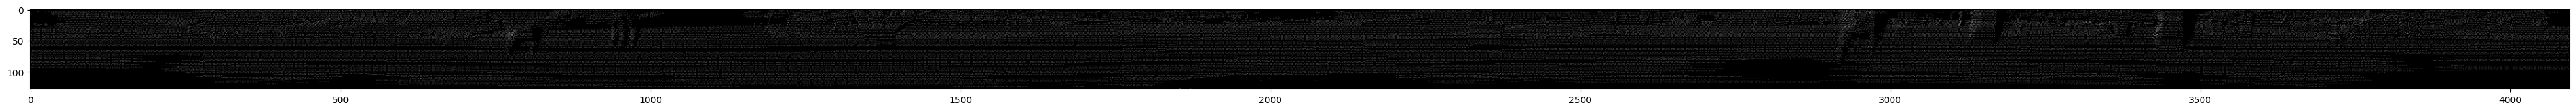

In [144]:
fig = plt.figure(figsize=(50, 50), dpi=100)
plt.imshow(override, cmap="gray")
#plt.show()
fig.savefig("override.png")

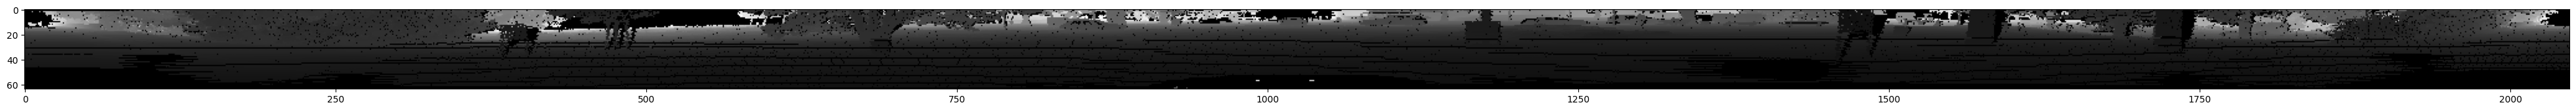

In [136]:
fig = plt.figure(figsize=(50, 50), dpi=100)
plt.imshow(proj_range0, cmap="gray")
#plt.show()
fig.savefig("depth0.png")

In [145]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points0)
pcd.colors = o3d.utility.Vector3dVector(override_colors)

o3d.io.write_point_cloud(log + "/override.ply", pcd)

True